In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm
import pandas as pd

sys.path.append('../../../lfi-models/')

from lfimodels.channelomics.ChannelSingle import ChannelSingle
from lfimodels.channelomics.ChannelStats import ChannelStats
%matplotlib inline

In [17]:
mpl_params = {'legend.fontsize': 19,
              'legend.frameon': False,
                      'axes.titlesize': 21,
                      'axes.labelsize': 20,
                      'xtick.labelsize': 19,
                      'ytick.labelsize': 19,
             'figure.figsize' : (18, 5), 
             'axes.titlepad': 2}

mpl.rcParams.update(mpl_params)

## Voltage-clamp protocol

In [3]:
prot = ['v_act','v_inact','v_deact']#,'v_ap','v_ramp']
p = 0
protocols = \
pd.read_csv('~/LRZBOX/Master/mackelab/code/lfi-models/lfimodels/channelomics/protocols/k_channels/'+prot[p]+'.dat',sep='\t')

protocols = protocols.drop(protocols.columns[-1],axis=1)

# extract voltages and time
protocols1 = protocols.values

V = protocols1[:,1:].T
t = protocols1[:,0]   # attention: time step varies, but we will assume that it is constant
tstep = np.mean(np.diff(t)) # ms

time_stamp = time.strftime('%Y%m%d%H%M_')

In [4]:
Vs = {}
ts = {}

for i, p in enumerate(prot): 
    protocols = pd.read_csv('~/LRZBOX/Master/mackelab/code/lfi-models/lfimodels/channelomics/protocols/k_channels/'+prot[i]+'.dat',sep='\t')
    protocols = protocols.drop(protocols.columns[-1],axis=1)

    # extract voltages and time
    protocols1 = protocols.values

    Vs[p] = protocols1[:,1:].T
    ts[p] = protocols1[:,0]   # attention: time step varies, but we will assume that it is constant
    

In [5]:
channel_type = 'kslow'

In [6]:
GT = {'kd': np.array([4, -63, 0.032, 15, 5, 0.5, 10, 40]),
      'kslow': np.array([1, 35, 10, 3.3, 20])}
LP = {'kd': [r'$M$', r'$V_T$', r'$R_{\alpha}$', r'$th_{\alpha}$', r'$q_{\alpha}$', r'$R_{\beta}$', r'$th_{\beta}$', r'$q_{\beta}$'],
      'kslow': [r'$M$', r'$th_{p}$', r'$q_{p}$', r'$R_{\tau}$', r'$q_{\tau}$']}

E_channel = {'kd': -90.0, 'kslow': -90.0}
fact_inward = {'kd': 1, 'kslow': 1}

cython = True

gt = GT[channel_type]
n_params = len(gt)
labels_params = LP[channel_type]
prior_lims = np.sort(np.concatenate((0.3 * gt.reshape(-1, 1), 1.3 * gt.reshape(-1, 1)), axis=1))

In [7]:
# generate observed data
n_params_obs = len(gt)
m_obs = ChannelSingle(channel_type=channel_type, n_params=n_params_obs, cython=cython)
s = ChannelStats(channel_type=channel_type)

xo = m_obs.gen(gt.reshape(1,-1))
xo_stats = s.calc(xo[0])

/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensiona

/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/Users/Jan/.local/lib/python3.6/site-packages/scipy-1.1.0-py3.6-macosx-10.7-x86_64.egg/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensiona

Text(0, 0.5, 'current')

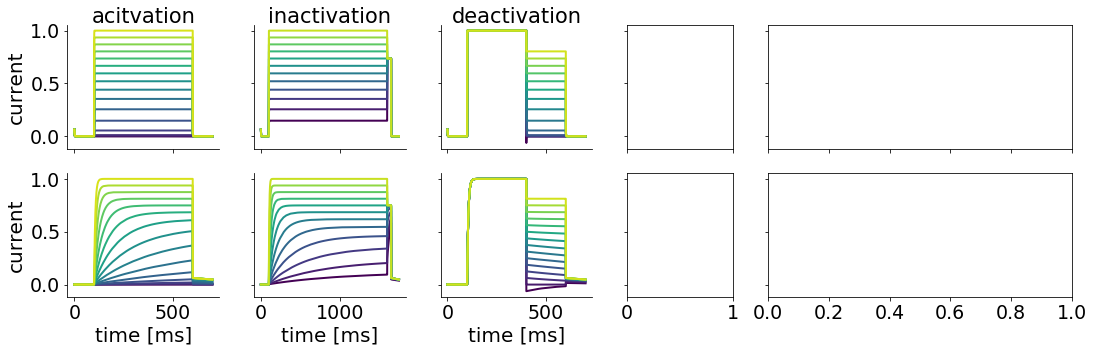

In [23]:
fig, ax = plt.subplots(2, 5, figsize=(18, 5), sharey='row', sharex='col', 
                       gridspec_kw = {'height_ratios':[1, 1], 
                                      'width_ratios': [1, 1, 1, .7, 2], 
                                      'wspace': .2})
prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
prot_labels = ['acitvation', 'inactivation', 'deactivation', 'action potentials', 'ramping']
channel_types = ['kd', 'kslow']

for ii, (k, v) in enumerate(Vs.items()): 
    
    # set colors 
    num_levels = v.shape[0]
    cm1 = mpl.cm.viridis
    col1 = [cm1(1. * k / num_levels) for k in range(num_levels)]
    
    ax[0, ii].set_title(prot_labels[ii])
    ax[1, ii].set_xlabel('time [ms]')
    
#     plt.sca(ax[0, ii])
#     for jj, subv in enumerate(v):
#         plt.plot(ts[k], subv, color='r')
    
    
    for ci, ch in enumerate(channel_types): 
        n_params_obs = len(gt)
        m_obs = ChannelSingle(channel_type=ch, n_params=n_params_obs, cython=cython)
        s = ChannelStats(channel_type=ch)
        gt = GT[ch]
        
        xo = m_obs.gen(gt.reshape(1,-1))
        xo_stats = s.calc(xo[0])
        I = xo[0][0][prot[ii]]['data']
        t = xo[0][0][prot[ii]]['time']    

        plt.sca(ax[ci, ii])
        ax[ci, ii].spines['top'].set_visible(False)
        ax[ci, ii].spines['right'].set_visible(False)
        for j in range(num_levels):
            plt.plot(t, xo[0][0][prot[ii]]['data'][j,], color = col1[j], lw=2)
        
    
# ax[0, 0].set_ylabel('voltage [mV]')
ax[1, 0].set_ylabel('current')
ax[0, 0].set_ylabel('current')

# plt.sca(ax[0, 3])
# plt.plot(np.log(model_idx_mdn.predict(sx_z)[:, 1]), '-o', alpha=.5)
# plt.plot(mtest, '-*')
# plt.xlabel('test set index')
# plt.ylabel(r'$p(m_{K_s} | s(x))$')
# plt.title('prediction on test set')

# plt.sca(ax[1, 3])
# plt.axis('off')

In [26]:
ax2 = plt.subplot2grid((2, 5), (0, 3), rowspan=2, colspan=2, fig=fig)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

width = .4
alpha = .7
x = np.arange(3) + width
ax2.bar(x + width, height=np.array([.02, .03, .01]), width=width, alpha=alpha)
ax2.bar(x + 2 * width, height=np.array([.04, .07, .2]), width=width, alpha=alpha)
ax2.set_xticklabels(['', 'gaussians', 'Poisson-NB', 'channels']);
ax2.set_ylabel('absolut error')
ax2.legend(['NDE', 'SMC'])
ax2.set_title('comparison to SMC')

Text(0.5, 1.0, 'comparison to SMC')

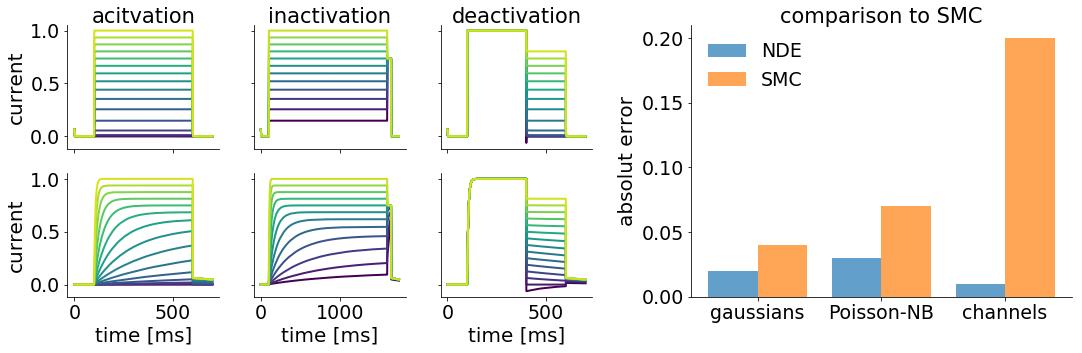

In [27]:
fig

In [28]:
fullpath = os.path.expanduser('~') + '/LRZBOX/PhD/writing/CogComp2018/poster/figs/fig4/fig4_raw.pdf'
fig.savefig(fullpath)

In [14]:
fn = time_stamp + 'voltageprots_currentraces_bothchannels.png'.format(channel_type)
fig.savefig(os.path.join('../figures', fn), dpi=300)